In [72]:
import torch.nn as nn
from torchvision.utils import save_image
import torch
import time
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import numpy as np
import matplotlib
import torchvision.utils
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
import matplotlib.animation as animation
from IPython.display import HTML
import torchvision.utils as vutils
matplotlib.style.use('ggplot')

## DCGAN

### Conceptually, how do DCGAN's work?

GANs generate new data from the same distribution as the training data. GANs consist of two models: a generator that produces synthetic images, and a discriminator that distinguishes between real and fake images. During training, the generator produces increasingly better fake images, while the discriminator becomes better at detecting and classifying real and fake images.

DCGAN uses convolutional layers in the Ddiscriminator model and convolutional-transpose layers in the generator model. 

[SOURCE](https://www.analyticsvidhya.com/blog/2021/07/deep-convolutional-generative-adversarial-network-dcgan-for-beginners/)

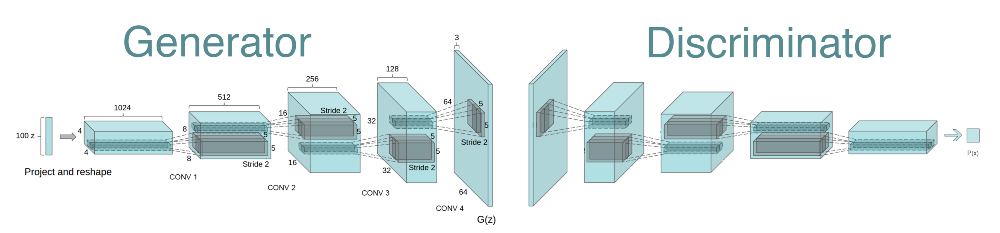

[DCGAN Code Source](https://debuggercafe.com/dcgan-pytorch/)

### The Generator
Let's start by defining the generator component of our DCGAN. Our generator will take a noise vector of size `nz` as input and will generate a realistic RGB image (hopefully). This is achieved by passing the noise vector through a series of transposed convolution layers, which upscale the noise vector to produce an image. We use `ConvTranspose2d` to upsample our noise vector.

In [42]:
# generator
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        # size of the noise vector
        self.nz = nz
        
        self.main = nn.Sequential(
            nn.ConvTranspose2d(
                nz, 128, kernel_size=4, 
                stride=2, padding=0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(
                128, 64, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(
                64, 32, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(
                32, 16, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(
                16, 3, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.Tanh()
        )
    def forward(self, input):
        return self.main(input)

### The Discriminator

To generate realistic fake data, our GAN (Generative Adversarial Network) uses a generator model. But how can we assess the realism of the fake data? One solution is to train a separate model, called the discriminator, to distinguish between real and fake images. The discriminator is trained on both real and fake data and learns to classify images as either real or fake. As the discriminator becomes better at identifying fake data, the generator model is encouraged to create more and more realistic fake images. The discriminator and generator are in a constant feedback loop, with the generator attempting to create more realistic fakes and the discriminator improving its ability to differentiate between real and fake data.

#### Activation Functions

In [43]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(
                3, 64, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                64, 32, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                32, 16, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                16, 8, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                8, 1, kernel_size=4, 
                stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input)

### Helper Functions

First, let's make a couple functions to label our real and fake data.

In [44]:
def create_real_labels(batch_size):
    # Create a tensor of size (batch_size, 1) with all values set to 1 to represent real images
    real_labels = torch.ones(batch_size, 1)
    # Move the tensor to the device (e.g. GPU) for faster processing if available
    return real_labels.to(device)

def create_fake_labels(batch_size):
    # Create a tensor of size (batch_size, 1) with all values set to 0 to represent fake images
    fake_labels = torch.zeros(batch_size, 1)
    # Move the tensor to the device (e.g. GPU) for faster processing if available
    return fake_labels.to(device)

Let's also create a function to generate random noise vectors. It is important to use different noise vectors each time we generate an image from the generator during training because it encourages the generator to produce diverse outputs that capture the underlying distribution of the training data, and it helps prevent overfitting to the training data.

In [45]:
def generate_noise_vector(num_samples, latent_dim):
    # Generate random noise with a normal distribution
    noise = torch.randn(num_samples, latent_dim, 1, 1)
    # Send the noise tensor to the appropriate device (e.g. CPU or GPU)
    noise = noise.to(device)
    return noise

We will need to initialize the weights of the generator and the discriminator from a zero-centered normal distribution as this can help ensure that the optimization process is stable and that the networks learn effectively. [source](https://debuggercafe.com/dcgan-pytorch/)

In [46]:
def weights_init(m):
    """
    Source: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Training

In [47]:
# set the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [48]:
# learning parameters / configurations according to paper
image_size = 64 # we need to resize image to 64x64
batch_size = 64
nz = 100 # latent vector size
beta1 = 0.5 # beta1 value for Adam optimizer
lr = 0.0002 # learning rate 
sample_size = 64 # fixed sample size
epochs = 5 # number of epoch to train

In [49]:
# image transforms
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), 
    (0.5, 0.5, 0.5)),
])

# prepare the data
train_data = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


In [50]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device) 

In [51]:
# initialize generator weights
generator.apply(weights_init);

In [52]:
# initialize discriminator weights
discriminator.apply(weights_init);

In [53]:
# loss function
criterion = nn.BCELoss()

In [54]:
def train_discriminator(optimizer, discriminator, data_real, data_fake):
    # batch size of real data
    b_size = data_real.size(0)
    
    # create real and fake label vectors
    real_label = create_real_labels(b_size).view(-1)
    fake_label = create_fake_labels(b_size).view(-1)
    
    # zero gradients 
    optimizer.zero_grad()
    
    # forward pass with the real data
    output_real = discriminator(data_real)
    output_real = output_real.view(-1)
    
    # compute loss between discriminator outputs and real label vectors
    loss_real = criterion(output_real, real_label)
    
    # forward pass with fake data 
    output_fake = discriminator(data_fake).view(-1)
    # compute loss between disciminator outputs and fake label vectors
    loss_fake = criterion(output_fake, fake_label)
    
    # compute gradients of the loss with respect to real data
    loss_real.backward()
    # compute the gradients of the loss with respect to fake data
    loss_fake.backward()
    
    # update the discriminator parameters
    optimizer.step()
    
    # Return the sum of the real and fake losses as the discriminator loss.
    return loss_real + loss_fake

In [55]:
def train_generator(optimizer, discriminator, generator, data_fake):
    # batch size of fake data
    b_size = data_fake.size(0)
    
    # create a tensor of real labels with the same batch size as the fake data
    real_label = create_real_labels(b_size).view(-1)
    
    # reset gradients of optimizer
    optimizer.zero_grad()
    
    # pass fake data to discriminator and flatten output tensor
    output = discriminator(data_fake).view(-1)
    
    # compute loss between discriminator output and real labels
    loss = criterion(output, real_label)
    
    # compute gradients 
    loss.backward()
    
    # update the generator parameters 
    optimizer.step()
    return loss

In [56]:
# create the noise vector
noise = generate_noise_vector(sample_size, nz)

In [57]:
generator.train()
discriminator.train();

In [58]:
def dcgan_trainer(generator, discriminator, train_loader, epochs, device, nz, lr_g, lr_d):
    start = time.perf_counter() 
    # optimizers
    optim_g = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
    optim_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

    losses_g = []
    losses_d = []
    img_list = []

    for epoch in range(epochs):
        epoch_loss_g = 0.0
        epoch_loss_d = 0.0

        # loop over batches 
        for batch_idx, (real_data, _) in tqdm(
            enumerate(train_loader),
            total=int(len(train_loader.dataset)/train_loader.batch_size)
        ):
            real_data = real_data.to(device)
            batch_size = real_data.size(0)

            # generate fake data with generator and detach from computation graph
            fake_data = generator(generate_noise_vector(batch_size, nz)).detach()

            # train discriminator with real and fake data
            d_loss = train_discriminator(optim_d, discriminator, real_data, fake_data)

            # generate fake data with generator (not detached)
            fake_data = generator(generate_noise_vector(batch_size, nz))

            # train generator to minimize discriminator's classification of fake data
            g_loss = train_generator(optim_g, discriminator, generator, fake_data)

            # accumulate losses for epoch
            epoch_loss_g += g_loss.item()
            epoch_loss_d += d_loss.item()

        # save the generated images
        with torch.no_grad():
            fake = generator(noise).detach().cpu()
        img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        # save losses for epoch
        losses_g.append(epoch_loss_g / (batch_idx + 1))
        losses_d.append(epoch_loss_d / (batch_idx + 1))

        # output loss stats for epoch
        print(f"Epoch {epoch+1} of {epochs}")
        print(f"Generator loss: {losses_g[-1]:.8f}, Discriminator loss: {losses_d[-1]:.8f}")
    
    end = time.perf_counter()
    # print training time
    print(f"Training time: {end - start:.6f} seconds")
    return losses_g, losses_d, img_list

In [59]:
losses_g, losses_d, img_list = dcgan_trainer(
    generator, discriminator, train_loader, epochs, device, nz, lr, lr
)

782it [07:48,  1.67it/s]                                                                                                                           


Epoch 1 of 5
Generator loss: 2.44514163, Discriminator loss: 0.45308701


782it [07:46,  1.68it/s]                                                                                                                           


Epoch 2 of 5
Generator loss: 2.19219266, Discriminator loss: 0.85087628


782it [07:35,  1.72it/s]                                                                                                                           


Epoch 3 of 5
Generator loss: 1.85905406, Discriminator loss: 0.92514449


782it [07:34,  1.72it/s]                                                                                                                           


Epoch 4 of 5
Generator loss: 1.66515720, Discriminator loss: 1.01320580


782it [07:51,  1.66it/s]                                                                                                                           


Epoch 5 of 5
Generator loss: 1.80117745, Discriminator loss: 0.89669329
Training time: 2316.338623 seconds


In [60]:
# save the model weights to disk
torch.save(generator.state_dict(), 'generator2.pth')

In [63]:
#losses_g = [loss.cpu().detach().numpy() for loss in losses_g]
#losses_d = [loss.cpu().detach().numpy() for loss in losses_d]

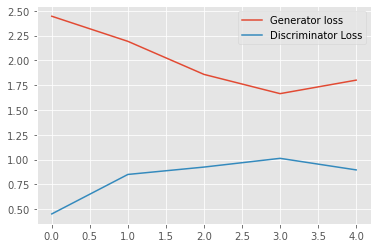

In [64]:
# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('loss.png')
plt.show()

In [69]:
def imshow(img):
    """
    Display a PyTorch tensor as an image using matplotlib
    """
    # unnormalize the image 
    img = img / 2 + 0.5
    npimg = img.numpy()
    
    # transpose numpy array from CxHxW to HxWxC format and display image 
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [85]:
img = generator(noise).detach().cpu()
images = img[9:10]

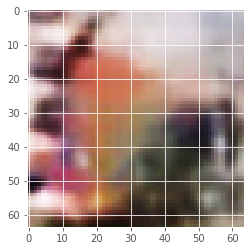

In [86]:
# display the batch
imshow(torchvision.utils.make_grid(images))

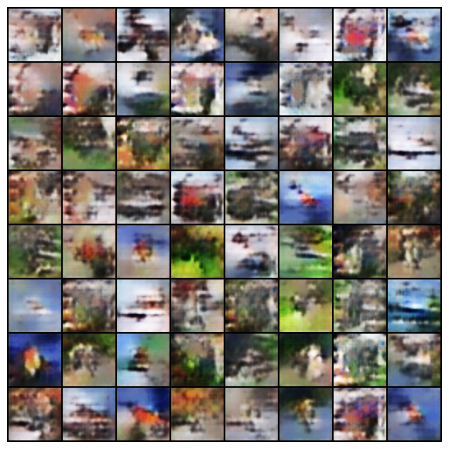

In [74]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

## PCA

Principal Component Analysis (PCA) reduces the dimensionality of a data set while retaining the most important information. It does this by finding linear combinations of the original variables that explain the most variance in the data. 

In [ ]:
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.mean = None
        self.components = None

    def fit(self, X):
        # calculate the mean of the input data
        self.mean = torch.mean(X, dim=0)

        # Center the input data by subtracting the mean
        X_centered = X - self.mean

        # the covariance matrix of the centered data
        cov = torch.matmul(X_centered.T, X_centered) / X.shape[0]

        # calculate eigenvectors of covariance matrix
        eigvals, eigvecs = torch.symeig(cov, eigenvectors=True)

        # Keep only the top n_components eigenvectors as the new basis
        self.components = eigvecs[:, -self.n_components:]

    def transform(self, X):
        # center the input data by subtracting the mean
        X_centered = X - self.mean

        # transform the centered data to the new basis
        return torch.matmul(X_centered, self.components)

    def fit_transform(self, X):
        # Fit the PCA model to the input data and transform it to the new basis
        self.fit(X)
        return self.transform(X)

## Cosine Similarity

## K-Means Clustering